In [2]:
%pip install import-ipynb

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

# Correct the path to your dataset
file_path = 'Dataset\Dataset\VG4_generator_data_testing_real_measurements.parquet'

# Load the dataset
try:
    data = pd.read_parquet(file_path)
except FileNotFoundError:
    print(f"File not found: {file_path}")

<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Turquin\AppData\Local\Temp\ipykernel_28172\467293860.py:4: SyntaxWarning: invalid escape sequence '\D'
  file_path = 'Dataset\Dataset\VG4_generator_data_testing_real_measurements.parquet'


File not found: Dataset\Dataset\VG4_generator_data_testing_real_measurements.parquet


In [4]:
import import_ipynb
import data_preprocessing


# Update the path to the correct location of the file
file_path = '.'

# Now you can use functions and variables from data_preprocessing
# For example, if data_preprocessing has a function named preprocess_data, you can call it like this:
# processed_data = data_preprocessing.preprocess_data(raw_data)

u4_control_vars = ['tot_activepower', 'plant_tmp', 'ext_tmp', 'canal_level', 'canal_tmp', 'lake_tmp', 'coupler_position', 'injector12_pressure', 'injector34_pressure', 'pump_rotspeed', 'turbine_rotspeed', 'turbine_cycle_id', 'pump_cycle_id', 'minute', 'hour', 'day', 'month', 'year', 'dayofweek', 'dayofyear', 'hour_sin', 'hour_cos', 'dayofyear_sin', 'dayofyear_cos', 'dayofweek_sin', 'dayofweek_cos', 'scaled_injector_sum', 'tot_activepower_lag_1', 'tot_activepower_lag_3', 'tot_activepower_lag_10', 'plant_tmp_lag_1', 'plant_tmp_lag_3', 'plant_tmp_lag_10', 'ext_tmp_lag_1', 'ext_tmp_lag_3', 'ext_tmp_lag_10', 'canal_level_lag_1', 'canal_level_lag_3', 'canal_level_lag_10', 'canal_tmp_lag_1', 'canal_tmp_lag_3', 'canal_tmp_lag_10', 'lake_tmp_lag_1', 'lake_tmp_lag_3', 'lake_tmp_lag_10', 'coupler_position_lag_1', 'coupler_position_lag_3', 'coupler_position_lag_10', 'injector12_pressure_lag_1', 'injector12_pressure_lag_3', 'injector12_pressure_lag_10', 'injector34_pressure_lag_1', 'injector34_pres

In [5]:
%pip install optuna

In [30]:
import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score, make_scorer, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, fbeta_score
from sklearn.metrics import matthews_corrcoef
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn import metrics
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score


import optuna
import torch
import torch.nn as nn
import torch.optim as optim


import warnings
warnings.filterwarnings("ignore")


### Code from josh_models.ipynb


In [7]:
# training data
u4_train_equil_turbine = data_preprocessing.u4_train_equil_turbine
u4_train_equil_pump = data_preprocessing.u4_train_equil_pump
u5_train_equil_turbine = data_preprocessing.u5_train_equil_turbine
u5_train_equil_pump = data_preprocessing.u5_train_equil_pump
u6_train_equil_turbine = data_preprocessing.u6_train_equil_turbine
u6_train_equil_pump = data_preprocessing.u6_train_equil_pump

# synethetic test sets
u5_s01_equil_turbine = data_preprocessing.u5_s01_equil_turbine
u5_s01_equil_pump = data_preprocessing.u5_s01_equil_pump
u5_s02_equil_turbine = data_preprocessing.u5_s02_equil_turbine
u5_s02_equil_pump = data_preprocessing.u5_s02_equil_pump
u6_s01_equil_turbine = data_preprocessing.u6_s01_equil_turbine
u6_s01_equil_pump = data_preprocessing.u6_s01_equil_pump
u6_s02_equil_turbine = data_preprocessing.u6_s02_equil_turbine
u6_s02_equil_pump = data_preprocessing.u6_s02_equil_pump

# real test sets
u4_test_equil_turbine = data_preprocessing.u4_test_equil_turbine
u4_test_equil_pump = data_preprocessing.u4_test_equil_pump
u5_test_equil_turbine = data_preprocessing.u5_test_equil_turbine
u5_test_equil_pump = data_preprocessing.u5_test_equil_pump
u6_test_equil_turbine = data_preprocessing.u6_test_equil_turbine
u6_test_equil_pump = data_preprocessing.u6_test_equil_pump

## Import Dependencies :

In [8]:
# Install essential libraries for deep learning and data processing
%pip install torch torchvision numpy tqdm

# Install libraries for audio analysis and feature extraction
%pip install librosa

# Install libraries for visualization and plotting
%pip install matplotlib

# Install libraries for machine learning metrics
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Define Auto Encoder


In [9]:


# Simplified Autoencoder
class FastAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(FastAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 16),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
        )

    def forward(self, x):
        feature = self.encoder(x)
        reconstruction = self.decoder(feature)
        return reconstruction, feature

class ComplexAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(ComplexAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 32),
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, input_dim),
        )

    def forward(self, x):
        feature = self.encoder(x)
        reconstruction = self.decoder(feature)
        return reconstruction, feature
    


class BestTunedAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(BestTunedAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),  # Hidden size: 256
            nn.ReLU(),
            nn.Dropout(0.38003433413765814),  # Dropout rate: ~0.38
            nn.Linear(256, 64),  # Latent dimension: 64
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),  # Latent dimension to hidden size
            nn.ReLU(),
            nn.Dropout(0.38003433413765814),  # Dropout rate: ~0.38
            nn.Linear(256, input_dim),  # Back to original input dimension
        )

    def forward(self, x):
        # Encode and decode
        feature = self.encoder(x)
        reconstruction = self.decoder(feature)
        return reconstruction, feature


# Data preprocessing
def preprocess_data_fast(df):
    # Scale data and convert to tensor
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    return torch.tensor(scaled_data, dtype=torch.float32), scaler

# Optimized training loop
def train_autoencoder_fast(model, train_data, val_data, epochs=27, batch_size=32, learning_rate=0.00021093546031606523):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            reconstruction, _ = model(batch)
            loss = criterion(reconstruction, batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                reconstruction, _ = model(batch)
                loss = criterion(reconstruction, batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    return model


## Hyper Parameters Tuning for AutoEncoder : 

In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing function (you need to define preprocess_data_fast)
def preprocess_data_fast(data):
    # Placeholder for your actual preprocessing logic
    # Return normalized/scaled data and a scaler object
    return torch.tensor(data.values, dtype=torch.float32), None  # Example

# Define an objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    num_epochs = trial.suggest_int("num_epochs", 5, 30)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    latent_dim = trial.suggest_categorical("latent_dim", [16, 32, 64])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    hidden_size = trial.suggest_categorical("hidden_size", [128, 256])

    # Define Autoencoder
    class TuningAutoencoder(nn.Module):
        def __init__(self, input_dim):
            super(TuningAutoencoder, self).__init__()
            self.encoder = nn.Sequential(
                nn.Linear(input_dim, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_size, latent_dim),
            )
            self.decoder = nn.Sequential(
                nn.Linear(latent_dim, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_size, input_dim),
            )

        def forward(self, x):
            feature = self.encoder(x)
            reconstruction = self.decoder(feature)
            return reconstruction, feature

    # Load and preprocess data
    input_dim = data_for_tuning.shape[1]
    model = TuningAutoencoder(input_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(10):  # Use more epochs for better tuning
        model.train()
        for batch in train_loader:
            x = batch[0].to(device)
            reconstruction, _ = model(x)
            loss = criterion(reconstruction, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                x = batch[0].to(device)
                reconstruction, _ = model(x)
                val_loss += criterion(reconstruction, x).item()

    return val_loss / len(val_loader)


# Load and preprocess your dataset


data_for_tuning = u5_train_equil_turbine  # Replace with your actual dataset
sample_data = data_for_tuning.sample(frac=0.2, random_state=42)  # Use 20% of the data

sample_data, scaler = preprocess_data_fast(sample_data)

# Train-validation split
train_data, val_data = train_test_split(sample_data.numpy(), test_size=0.2, random_state=42)
train_tensor = TensorDataset(torch.tensor(train_data, dtype=torch.float32))
val_tensor = TensorDataset(torch.tensor(val_data, dtype=torch.float32))

# Create DataLoader
train_loader = DataLoader(train_tensor, batch_size=32, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=32, shuffle=False)

# Run the hyperparameter search
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# Best parameters
print("Best hyperparameters:", study.best_params)


[I 2024-12-11 12:33:24,658] A new study created in memory with name: no-name-4b335dd6-8059-433c-9e87-7b08f1ce1a94
[I 2024-12-11 12:33:46,770] Trial 0 finished with value: 1807.870409305279 and parameters: {'num_epochs': 22, 'learning_rate': 0.0017679765353233463, 'latent_dim': 16, 'dropout_rate': 0.14332613677257658, 'hidden_size': 128}. Best is trial 0 with value: 1807.870409305279.
[I 2024-12-11 12:34:08,071] Trial 1 finished with value: 1155.7760708148662 and parameters: {'num_epochs': 18, 'learning_rate': 0.0030484671791901666, 'latent_dim': 16, 'dropout_rate': 0.19299578269584725, 'hidden_size': 128}. Best is trial 1 with value: 1155.7760708148662.
[I 2024-12-11 12:34:31,858] Trial 2 finished with value: 10870.779463547926 and parameters: {'num_epochs': 12, 'learning_rate': 0.007531816279893501, 'latent_dim': 16, 'dropout_rate': 0.3198558393967693, 'hidden_size': 128}. Best is trial 1 with value: 1155.7760708148662.
[I 2024-12-11 12:35:03,825] Trial 3 finished with value: 106.0752

Best hyperparameters: {'num_epochs': 27, 'learning_rate': 0.00021093546031606523, 'latent_dim': 64, 'dropout_rate': 0.38003433413765814, 'hidden_size': 256}


to do if we skip the hyper parameters :

In [17]:
# data_for_tuning = u5_train_equil_turbine  # Replace with your actual dataset
# sample_data = data_for_tuning.sample(frac=0.2, random_state=42)  # Use 20% of the data

# sample_data, scaler = preprocess_data_fast(sample_data)


In [ ]:

# Preprocess u4_train_equil_turbine
u4_train_data, scaler = preprocess_data_fast(u4_train_equil_turbine)

# Train-validation split
train_tensor, val_tensor = train_test_split(u4_train_data, test_size=0.2, random_state=42)

# Initialize and train the autoencoder
input_dim = train_tensor.shape[1]
model = FastAutoencoder(input_dim)
u4_turbine_trained_model = train_autoencoder_fast(model, train_tensor, val_tensor)


In [12]:
# Preprocess the test data
def preprocess_test_data(test_df, train_columns, scaler):
    # Reindex test_df to match the columns of the training data
    test_df = test_df.reindex(columns=train_columns, fill_value=0)
    # Use the same scaler from the training data
    scaled_test_data = scaler.transform(test_df)
    return torch.tensor(scaled_test_data, dtype=torch.float32)

# Evaluate reconstruction error
def evaluate_reconstruction(model, test_data):
    model.eval()
    with torch.no_grad():
        reconstruction, _ = model(test_data)
        reconstruction_error = torch.mean((reconstruction - test_data) ** 2, dim=1)
    return reconstruction_error




def visualize_anomalies(reconstruction_errors, anomaly_scores, threshold):
    """
    Visualize reconstruction errors and detected anomalies.

    Args:
        reconstruction_errors (torch.Tensor): Reconstruction errors for the test data.
        anomaly_scores (torch.Tensor): Binary tensor indicating anomalies (1 for anomaly, 0 for normal).
        threshold (float or torch.Tensor): Threshold value used for anomaly detection.
    """
    # Ensure threshold is a float for consistent handling
    if isinstance(threshold, torch.Tensor):
        threshold = threshold.item()

    plt.figure(figsize=(10, 6))
    plt.plot(reconstruction_errors.numpy(), label="Reconstruction Error")
    plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold ({threshold:.4f})")
    plt.scatter(
        range(len(anomaly_scores)), 
        reconstruction_errors.numpy(), 
        c=anomaly_scores.numpy(), 
        cmap='coolwarm', 
        label="Anomalies"
    )
    plt.title("Reconstruction Errors and Detected Anomalies")
    plt.xlabel("Time Steps")
    plt.ylabel("Reconstruction Error")
    plt.legend()
    plt.show()

from sklearn.metrics import fbeta_score

def define_anomaly_score(reconstruction_errors, threshold):
    """
    Define anomaly scores based on a given threshold.

    Args:
        reconstruction_errors (torch.Tensor): The reconstruction errors for the test data.
        threshold (float): Threshold value for anomaly detection.

    Returns:
        torch.Tensor: Binary tensor indicating anomalies (1 for anomaly, 0 for normal).
    """
    # Generate binary predictions based on the threshold
    anomaly_scores = (reconstruction_errors > threshold).int()
    return anomaly_scores



def find_optimal_threshold_by_distance(ground_truth, reconstruction_errors):
    """
    Finds the optimal threshold by minimizing the distance to the top-left corner of the ROC curve.

    """
    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(ground_truth, reconstruction_errors)
    
    # Compute the distance to the top-left corner
    distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)
    
    # Find the threshold that minimizes the distance
    optimal_idx = distances.argmin()
    optimal_threshold = thresholds[optimal_idx]
    optimal_distance = distances[optimal_idx]

    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Optimal Distance: {optimal_distance:.4f}")
    
    return optimal_threshold, optimal_distance


def custom_score(tp, fp, fn, tn, penalty_fp=2.0, penalty_fn=1.0):
    
    tp_rate = tp / (tp + fn + 1e-6)  # Sensitivity/Recall
    fp_rate = fp / (fp + tn + 1e-6)  # False positive rate
    fn_rate = fn / (fn + tp + 1e-6)  # False negative rate

    # Apply penalties to FP and FN
    return tp_rate - penalty_fp * fp_rate - penalty_fn * fn_rate



In [ ]:

# Example usage for u4_test_equil_turbine
# Assume `trained_model` is the autoencoder trained on u4_train_equil_turbine
# Assume `scaler` is the StandardScaler fitted to u4_train_equil_turbine

# Preprocess test data
u4_test_data = preprocess_test_data(u4_test_equil_turbine, u4_train_equil_turbine.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u4_turbine_trained_model, u4_test_data)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)

In [ ]:
print(anomaly_scores)

## For  u4_train_equil_pump

In [ ]:
# Preprocess u4_train_equil_pump
u4_train_pump_data, scaler = preprocess_data_fast(u4_train_equil_pump)

# Train-validation split
train_tensor, val_tensor = train_test_split(u4_train_pump_data, test_size=0.2, random_state=42)

# Initialize and train the autoencoder
input_dim = train_tensor.shape[1]
model = FastAutoencoder(input_dim)
u4_pump_trained_model = train_autoencoder_fast(model, train_tensor, val_tensor)


#### Train on test dataset

In [ ]:
# Example usage for u4_test_equil_pump
# Assume `trained_model` is the autoencoder trained on u4_train_equil_pump
# Assume `scaler` is the StandardScaler fitted to u4_train_equil_pump

# Preprocess test data
u4_test_pump_data = preprocess_test_data(u4_test_equil_pump, u4_train_equil_pump.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u4_pump_trained_model, u4_test_pump_data)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


## For u5_train_equil_turbine


In [15]:
# # Preprocess u5_train_equil_turbine
# u5_train_turbine_data, scaler = preprocess_data_fast(u5_train_equil_turbine)

# # Train-validation split
# train_tensor, val_tensor = train_test_split(u5_train_turbine_data, test_size=0.2, random_state=42)

# # Initialize and train the autoencoder
# input_dim = train_tensor.shape[1]
# model = FastAutoencoder(input_dim)
# u5_turbine_trained_model = train_autoencoder_fast(model, train_tensor, val_tensor)

In [16]:

# Preprocess u5_train_equil_turbine with scaler validation
scaler = StandardScaler()  # Initialize scaler
u5_train_turbine_scaled = scaler.fit_transform(u5_train_equil_turbine)  # Fit scaler and transform data
u5_train_turbine_data = torch.tensor(u5_train_turbine_scaled, dtype=torch.float32)  # Convert to tensor

# Train-validation split
train_tensor, val_tensor = train_test_split(u5_train_turbine_data, test_size=0.2, random_state=42)

# Initialize and train the autoencoder
input_dim = data_for_tuning.shape[1]
model = BestTunedAutoencoder(input_dim) ## Use either BestTunedAutoencoder,  ComplexAutoencoder or FastAutoencoder 
u5_turbine_trained_model = train_autoencoder_fast(model, train_tensor, val_tensor)


Epoch 1/27, Train Loss: 0.2223, Validation Loss: 0.1000
Epoch 2/27, Train Loss: 0.1617, Validation Loss: 0.0838
Epoch 3/27, Train Loss: 0.1517, Validation Loss: 0.0791
Epoch 4/27, Train Loss: 0.1470, Validation Loss: 0.0749
Epoch 5/27, Train Loss: 0.1425, Validation Loss: 0.0746
Epoch 6/27, Train Loss: 0.1401, Validation Loss: 0.0699
Epoch 7/27, Train Loss: 0.1368, Validation Loss: 0.0705
Epoch 8/27, Train Loss: 0.1353, Validation Loss: 0.0658
Epoch 9/27, Train Loss: 0.1352, Validation Loss: 0.0640
Epoch 10/27, Train Loss: 0.1336, Validation Loss: 0.0666
Epoch 11/27, Train Loss: 0.1328, Validation Loss: 0.0673
Epoch 12/27, Train Loss: 0.1311, Validation Loss: 0.0619
Epoch 13/27, Train Loss: 0.1304, Validation Loss: 0.0626
Epoch 14/27, Train Loss: 0.1301, Validation Loss: 0.0577
Epoch 15/27, Train Loss: 0.1295, Validation Loss: 0.0567
Epoch 16/27, Train Loss: 0.1291, Validation Loss: 0.0574
Epoch 17/27, Train Loss: 0.1273, Validation Loss: 0.0581
Epoch 18/27, Train Loss: 0.1284, Validat

#### for synthetic anomalies : s01

Optimal Threshold: 0.1204
Optimal Distance: 0.7335
Optimal Threshold: 0.12040086090564728


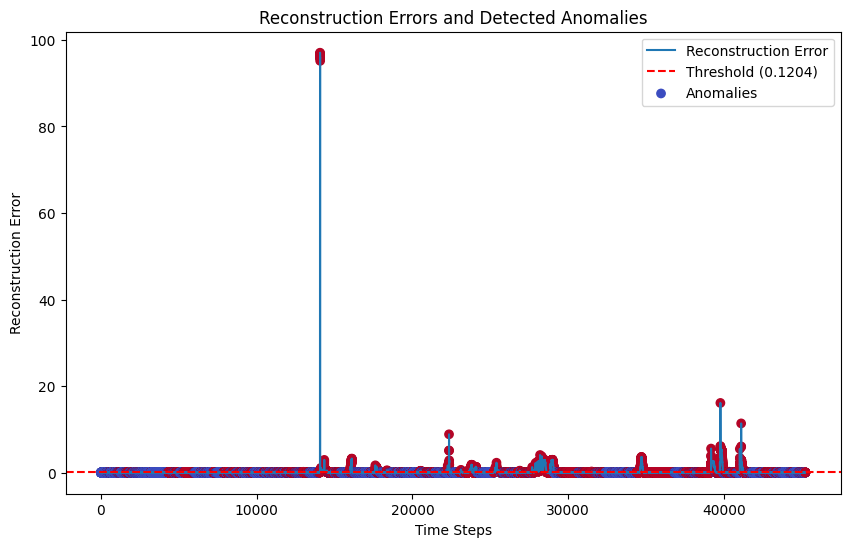

In [18]:
# Example usage for u5_s01_equil_turbine
# Assume `u5_turbine_trained_model` is the autoencoder trained on u5_train_equil_turbine
# Assume `scaler` is the StandardScaler fitted to u5_train_equil_turbine during training

# Ensure that the columns in the test data match the training data
u5_s01_turbine_data_preprocessed = preprocess_test_data(u5_s01_equil_turbine, u5_train_equil_turbine.columns, scaler)

ground_truth = u5_s01_equil_turbine['anomaly']  # Replace 'anomaly' with the actual column name

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u5_turbine_trained_model, u5_s01_turbine_data_preprocessed)

# Define anomaly scores and threshold
# Ensure reconstruction_errors and threshold are tensors
reconstruction_errors = torch.tensor(reconstruction_errors, dtype=torch.float32)
# threshold = torch.tensor(threshold, dtype=torch.float32)

best_score = -float("inf")

# Ensure ground_truth is a tensor
ground_truth = torch.tensor(u5_s01_equil_turbine['anomaly'].values, dtype=torch.int)

# thresholds = torch.linspace(reconstruction_errors.min().item(), reconstruction_errors.max().item(), steps=100)
# for th in thresholds:
#     anomaly_scores = (reconstruction_errors > th).int()
#     tp = ((anomaly_scores == 1) & (ground_truth == 1)).sum().item()
#     fp = ((anomaly_scores == 1) & (ground_truth == 0)).sum().item()
#     fn = ((anomaly_scores == 0) & (ground_truth == 1)).sum().item()
#     tn = ((anomaly_scores == 0) & (ground_truth == 0)).sum().item()

#     score = custom_score(tp, fp, fn, tn, penalty_fp=3,penalty_fn=2.)
#     if score > best_score:
#         best_score = score
#         best_threshold = th.item()



# Find the optimal threshold
optimal_threshold, optimal_distance = find_optimal_threshold_by_distance(ground_truth, reconstruction_errors)

# Print and use the optimal threshold
print(f"Optimal Threshold: {optimal_threshold}")



anomaly_scores = define_anomaly_score(reconstruction_errors, optimal_threshold)
detected_anomalies = anomaly_scores  # Use the previously calculated anomaly scores
threshold = optimal_threshold  # Use the float value directly
optimal_threshold_s1=optimal_threshold


# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


In [19]:
# Assuming `anomaly_scores` is already calculated in the previous cells


ground_truth = u5_s01_equil_turbine['anomaly']  # Replace 'anomaly' with the actual column name
detected_anomalies = anomaly_scores  # Use the previously calculated anomaly scores

ground_truth = np.array(ground_truth)
detected_anomalies = np.array(detected_anomalies)

accuracy = accuracy_score(ground_truth, detected_anomalies)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.47


In [20]:

# Assuming ground_truth is a binary array (1 for anomaly, 0 for normal) from the synthetic info file
# Replace 'anomaly' with the actual column name containing the labels
ground_truth = u5_s01_equil_turbine['anomaly'].values

# Detected anomalies (binary array where 1 indicates an anomaly and 0 indicates normal)
detected_anomalies = (reconstruction_errors > threshold).int()

ground_truth = np.array(ground_truth)
detected_anomalies = np.array(detected_anomalies)

# Calculate Precision, Recall, and F1-Score
precision = precision_score(ground_truth, detected_anomalies)
recall = recall_score(ground_truth, detected_anomalies)
f1 = f1_score(ground_truth, detected_anomalies)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Precision: 0.64
Recall: 0.46
F1-Score: 0.53


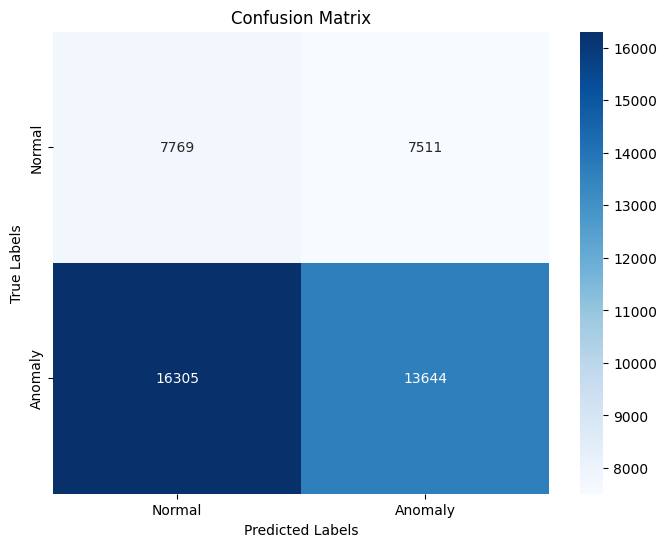

In [21]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(ground_truth, detected_anomalies)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


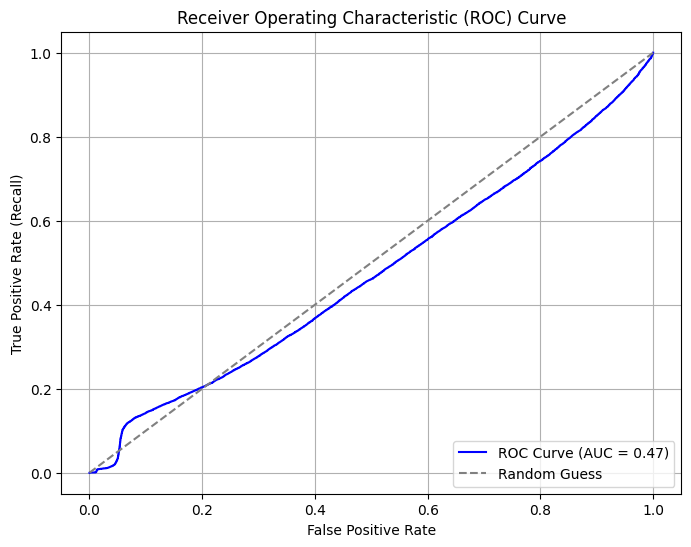

In [22]:
# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(ground_truth, reconstruction_errors)
roc_auc = roc_auc_score(ground_truth, reconstruction_errors)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


#### for synthetic anomaly s02 :

Optimal Threshold: 0.1892
Optimal Distance: 0.8440
Optimal Threshold: 0.1891503781080246


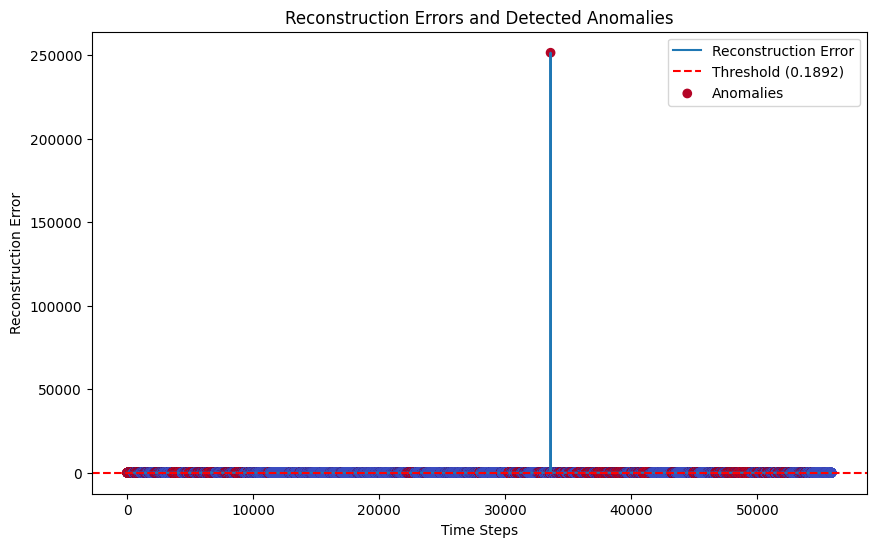

In [23]:
# Example usage for u5_s01_equil_turbine
# Assume `u5_turbine_trained_model` is the autoencoder trained on u5_train_equil_turbine
# Assume `scaler` is the StandardScaler fitted to u5_train_equil_turbine during training

# Ensure that the columns in the test data match the training data
u5_s02_turbine_data_preprocessed = preprocess_test_data(u5_s02_equil_turbine, u5_train_equil_turbine.columns, scaler)

ground_truth = u5_s02_equil_turbine['anomaly']  # Replace 'anomaly' with the actual column name

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u5_turbine_trained_model, u5_s02_turbine_data_preprocessed)

# Define anomaly scores and threshold
# Ensure reconstruction_errors and threshold are tensors
reconstruction_errors = torch.tensor(reconstruction_errors, dtype=torch.float32)
# threshold = torch.tensor(threshold, dtype=torch.float32)

best_score = -float("inf")

# Ensure ground_truth is a tensor
ground_truth = torch.tensor(u5_s02_equil_turbine['anomaly'].values, dtype=torch.int)


# Find the optimal threshold
optimal_threshold, optimal_distance = find_optimal_threshold_by_distance(ground_truth, reconstruction_errors)

# Print and use the optimal threshold
print(f"Optimal Threshold: {optimal_threshold}")


anomaly_scores = define_anomaly_score(reconstruction_errors, optimal_threshold)
detected_anomalies = anomaly_scores  # Use the previously calculated anomaly scores
threshold = optimal_threshold  # Use the float value directly
optimal_threshold_s2=optimal_threshold

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


In [24]:
# Assuming `anomaly_scores` is already calculated in the previous cells
ground_truth_u5_s02_T = u5_s02_equil_turbine['anomaly']  # Replace 'anomaly' with the actual column name
detected_anomalies_u5_s02_T = anomaly_scores  # Use the previously calculated anomaly scores

ground_truth_u5_s02_T = np.array(ground_truth)
detected_anomalies_u5_s02_T = np.array(detected_anomalies)


accuracy_u5_s02_T = accuracy_score(ground_truth_u5_s02_T, detected_anomalies_u5_s02_T)
print(f"Accuracy: {accuracy_u5_s02_T:.2f}") 

Accuracy: 0.32


In [25]:

# Assuming ground_truth is a binary array (1 for anomaly, 0 for normal) from the synthetic info file
# Replace 'anomaly' with the actual column name containing the labels
ground_truth_u5_s02_T = u5_s02_equil_turbine['anomaly'].values

# Detected anomalies (binary array where 1 indicates an anomaly and 0 indicates normal)
detected_anomalies_u5_s02_T = (reconstruction_errors > threshold).int()

ground_truth_u5_s02_T = np.array(ground_truth)
detected_anomalies_u5_s02_T = np.array(detected_anomalies)

# Calculate Precision, Recall, and F1-Score
precision_u5_s02_T = precision_score(ground_truth_u5_s02_T, detected_anomalies_u5_s02_T)
recall_u5_s02_T = recall_score(ground_truth_u5_s02_T, detected_anomalies_u5_s02_T)
f1_u5_s02_T = f1_score(ground_truth_u5_s02_T, detected_anomalies_u5_s02_T)

print(f"Precision: {precision_u5_s02_T:.2f}")
print(f"Recall: {recall_u5_s02_T:.2f}")
print(f"F1-Score: {f1_u5_s02_T:.2f}")


Precision: 0.77
Recall: 0.26
F1-Score: 0.39


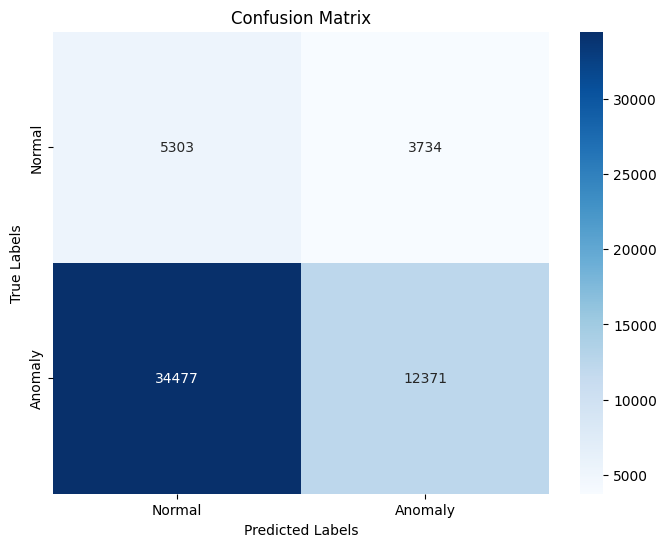

In [26]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(ground_truth_u5_s02_T, detected_anomalies_u5_s02_T)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


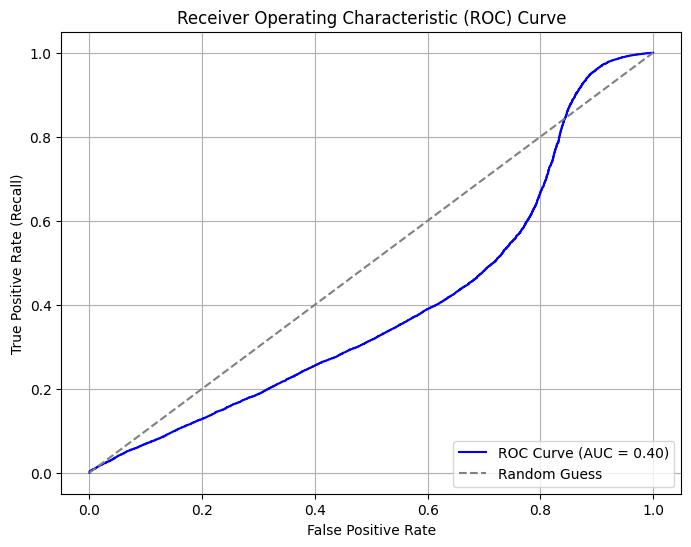

In [27]:
# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(ground_truth_u5_s02_T, reconstruction_errors)
roc_auc = roc_auc_score(ground_truth_u5_s02_T, reconstruction_errors)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


#### for test anomalies : 

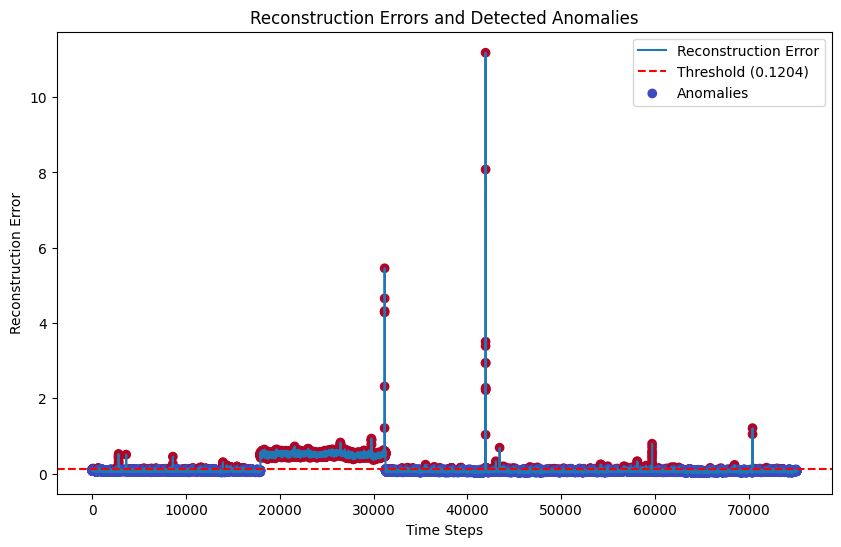

In [28]:
# Example usage for u5_test_equil_turbine
# Assume `u5_turbine_trained_model` is the autoencoder trained on u5_train_equil_turbine
# Assume `scaler` is the StandardScaler fitted to u5_train_equil_turbine during training

# Ensure that the columns in the test data match the training data
u5_test_turbine_data_preprocessed = preprocess_test_data(u5_test_equil_turbine, u5_train_equil_turbine.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u5_turbine_trained_model, u5_test_turbine_data_preprocessed)


test_threshold = min(optimal_threshold_s1,optimal_threshold_s2)

anomaly_scores = define_anomaly_score(reconstruction_errors, test_threshold)
detected_anomalies = anomaly_scores  # Use the previously calculated anomaly scores
threshold = test_threshold  # Use the float value directly


# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


### Try with an isolation forest :

### HyperParameters tuning for Isolation Forest :

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best Parameters found:
{'n_estimators': 100, 'max_samples': 0.8, 'max_features': 1.0, 'contamination': 0.05, 'bootstrap': False}
Best F1-Score: nan
ROC AUC Score: 0.3613
Accuracy: 0.6550
F1-Score: 0.7912
Confusion Matrix:
                Predicted Normal  Predicted Anomaly
Actual Normal                 65              15215
Actual Anomaly               388              29561


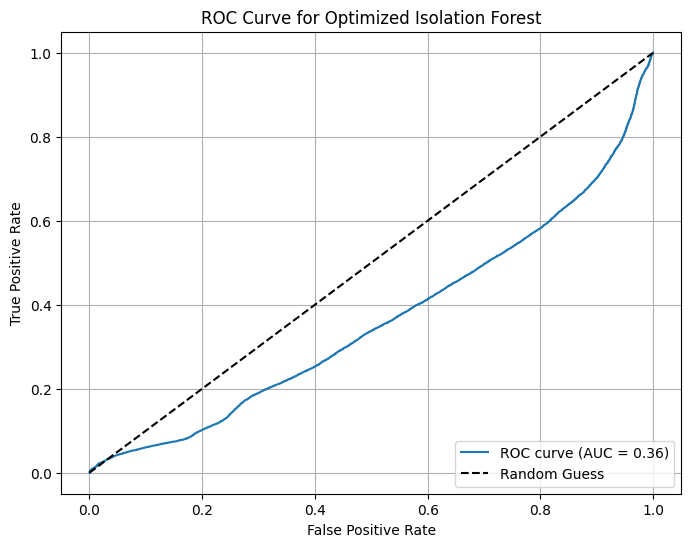

In [31]:

# Define scoring function
def f1_scorer(y_true, y_pred):
    return f1_score(y_true, y_pred)

# Define a reduced parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_samples': [0.8, 0.9],
    'contamination': [0.05, 0.1],
    'max_features': [1.0, 0.8],
    'bootstrap': [False]
}

# Initialize the Isolation Forest
isolation_forest = IsolationForest(random_state=42)

# Use RandomizedSearchCV instead of GridSearchCV
random_search = RandomizedSearchCV(
    estimator=isolation_forest,
    param_distributions=param_grid,
    scoring=make_scorer(f1_scorer),
    n_iter=10,  # Test only 10 random combinations
    cv=2,  # Reduce cross-validation folds to 2
    n_jobs=-1,  # Use all available cores
    verbose=2,
    random_state=42
)

# Subsample the training dataset to reduce computational time
subset = u5_train_equil_turbine.sample(frac=0.2, random_state=42)  # Use only 20% of the data for tuning

# Fit RandomizedSearchCV
random_search.fit(subset)

# Display the best parameters
print("Best Parameters found:")
print(random_search.best_params_)

# Display the best score
print(f"Best F1-Score: {random_search.best_score_:.4f}")

# Retrieve the best model
best_isolation_forest = random_search.best_estimator_

# Predict anomaly scores on the test set
predicted_scores = best_isolation_forest.decision_function(u5_s01_turbine_data_preprocessed)

# Define a threshold (e.g., 99th percentile)
threshold = np.percentile(predicted_scores, 99)

# Classify as anomalies based on the threshold
y_pred = (predicted_scores <= threshold).astype(int)

# Calculate evaluation metrics
roc_auc = roc_auc_score(u5_s01_equil_turbine['anomaly'], -predicted_scores)
accuracy = np.mean(y_pred == u5_s01_equil_turbine['anomaly'])
f1 = f1_score(u5_s01_equil_turbine['anomaly'], y_pred)
conf_matrix = pd.DataFrame(
    confusion_matrix(u5_s01_equil_turbine['anomaly'], y_pred),
    index=['Actual Normal', 'Actual Anomaly'],
    columns=['Predicted Normal', 'Predicted Anomaly']
)

# Display metrics
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Compute ROC curve
fpr, tpr, thresholds_roc = roc_curve(u5_s01_equil_turbine['anomaly'], -predicted_scores)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Optimized Isolation Forest")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


#### for u5_S01

In [34]:
# Define the IsolationForest
isolation_forest = IsolationForest(bootstrap=False, contamination='auto', max_features=1.0, max_samples='auto', n_estimators=100)

# Fit IsolationForest using training data
isolation_forest.fit(u5_train_equil_turbine)

# Predict using IsolationForest
predicted_score = isolation_forest.decision_function(u5_s01_turbine_data_preprocessed)

# Report essential evaluation metrics
roc_auc = metrics.roc_auc_score(u5_s01_equil_turbine['anomaly'], -predicted_score)
print(f"ROC AUC Score: {roc_auc}")

# Define a threshold based on the predicted score for classification using top-left distance
def find_best_threshold_isolation_forest(predicted_score, y_true):
    fpr, tpr, thresholds = roc_curve(y_true, -predicted_score)
    distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)
    best_threshold_idx = np.argmin(distances)
    best_threshold = thresholds[best_threshold_idx]
    best_distance = distances[best_threshold_idx]

    print(f"Best Threshold: {best_threshold}")
    print(f"Best Distance: {best_distance}")
    return best_threshold

best_threshold_IF = find_best_threshold_isolation_forest(predicted_score, u5_s01_equil_turbine['anomaly'])
threshold = best_threshold_IF


# Classify based on the threshold
y_pred = (predicted_score <= threshold).astype(int)

# Calculate accuracy
accuracy = metrics.accuracy_score(u5_s01_equil_turbine['anomaly'], y_pred)
print(f"Accuracy: {accuracy}")

# Calculate TPR (True Positive Rate) and FPR (False Positive Rate)
confusion_matrix = metrics.confusion_matrix(u5_s01_equil_turbine['anomaly'], y_pred)
tn, fp, fn, tp = confusion_matrix.ravel()
tpr = tp / (tp + fn)  # Sensitivity, hit rate, recall, or true positive rate
fpr = fp / (fp + tn)  # Fall-out or false positive rate
print(f"TPR (True Positive Rate): {tpr}")
print(f"FPR (False Positive Rate): {fpr}")

# Calculate F1-Score
f1_score = metrics.f1_score(u5_s01_equil_turbine['anomaly'], y_pred)
print(f"F1-Score: {f1_score}")


ROC AUC Score: 0.34398855235401055
Best Threshold: 0.005598245423040549
Best Distance: 0.8417774724772631
Accuracy: 0.3949899400826903
TPR (True Positive Rate): 0.41774349727870713
FPR (False Positive Rate): 0.6496073298429319
F1-Score: 0.4776466994998664


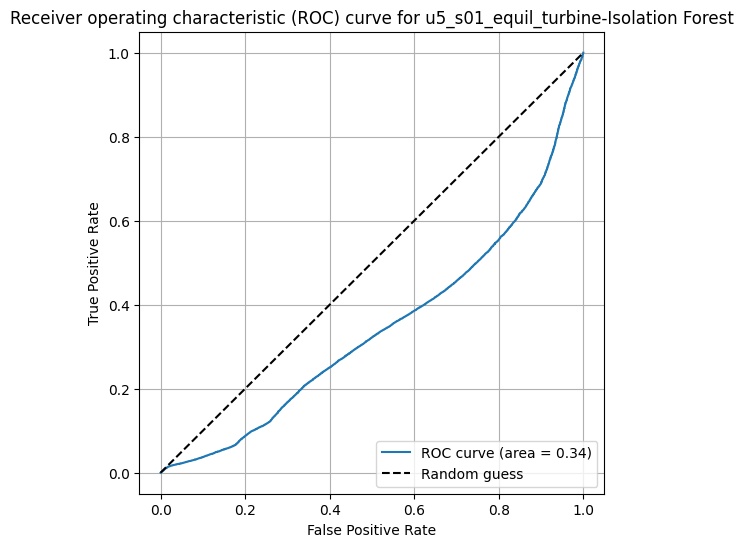

In [35]:
# Compute ROC curve points
fpr_values, tpr_values, _ = roc_curve(u5_s01_equil_turbine['anomaly'], -predicted_score)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr_values, tpr_values, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Receiver operating characteristic (ROC) curve for u5_s01_equil_turbine-Isolation Forest")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## for u5_train_equil_Pump 

In [ ]:
# Preprocess u5_train_equil_pump
u5_train_pump_data, scaler = preprocess_data_fast(u5_train_equil_pump)

# Train-validation split
train_tensor, val_tensor = train_test_split(u5_train_pump_data, test_size=0.2, random_state=42)

# Initialize and train the autoencoder
input_dim = train_tensor.shape[1]
model = FastAutoencoder(input_dim)
u5_pump_trained_model = train_autoencoder_fast(model, train_tensor, val_tensor)

#### For Synthetic anomaly s01

In [ ]:
# Example usage for u5_s01_equil_pump
# Assume `u5_pump_trained_model` is the autoencoder trained on u5_train_equil_pump
# Assume `scaler` is the StandardScaler fitted to u5_train_equil_pump during training

# Ensure that the columns in the test data match the training data
u5_s01_pump_data_preprocessed = preprocess_test_data(u5_s01_equil_pump, u5_train_equil_pump.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u5_pump_trained_model, u5_s01_pump_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


#### for synthetic anomalies s02 : 

In [ ]:
# Example usage for u5_s02_equil_pump
# Assume `u5_pump_trained_model` is the autoencoder trained on u5_train_equil_pump
# Assume `scaler` is the StandardScaler fitted to u5_train_equil_pump during training

# Ensure that the columns in the test data match the training data
u5_s02_pump_data_preprocessed = preprocess_test_data(u5_s02_equil_pump, u5_train_equil_pump.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u5_pump_trained_model, u5_s02_pump_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


#### For Test data set 

In [ ]:
# Example usage for u5_test_equil_pump
# Assume `u5_pump_trained_model` is the autoencoder trained on u5_train_equil_pump
# Assume `scaler` is the StandardScaler fitted to u5_train_equil_pump during training

# Ensure that the columns in the test data match the training data
u5_test_pump_data_preprocessed = preprocess_test_data(u5_test_equil_pump, u5_train_equil_pump.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u5_pump_trained_model, u5_test_pump_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


## For u6_train_equil_turbine

In [ ]:
# Preprocess u6_train_equil_turbine
u6_train_turbine_data, scaler = preprocess_data_fast(u6_train_equil_turbine)

# Train-validation split
train_tensor, val_tensor = train_test_split(u6_train_turbine_data, test_size=0.2, random_state=42)

# Initialize and train the autoencoder
input_dim = train_tensor.shape[1]
model = FastAutoencoder(input_dim)
u6_turbine_trained_model = train_autoencoder_fast(model, train_tensor, val_tensor)

#### Synthetic anomaly s01 :

In [ ]:
# Example usage for u6_s01_equil_turbine
# Assume `u6_turbine_trained_model` is the autoencoder trained on u6_train_equil_turbine
# Assume `scaler` is the StandardScaler fitted to u6_train_equil_turbine during training

# Ensure that the columns in the test data match the training data
u6_s01_turbine_data_preprocessed = preprocess_test_data(u6_s01_equil_turbine, u6_train_equil_turbine.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u6_turbine_trained_model, u6_s01_turbine_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


#### Synthetic anomaly s02 : 

In [ ]:
# Example usage for u6_s02_equil_turbine
# Assume `u6_turbine_trained_model` is the autoencoder trained on u6_train_equil_turbine
# Assume `scaler` is the StandardScaler fitted to u6_train_equil_turbine during training

# Ensure that the columns in the test data match the training data
u6_s02_turbine_data_preprocessed = preprocess_test_data(u6_s02_equil_turbine, u6_train_equil_turbine.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u6_turbine_trained_model, u6_s02_turbine_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)

#### For Test data set : 

In [ ]:
# Example usage for u6_test_equil_turbine
# Assume `u6_turbine_trained_model` is the autoencoder trained on u6_train_equil_turbine
# Assume `scaler` is the StandardScaler fitted to u6_train_equil_turbine during training

# Ensure that the columns in the test data match the training data
u6_test_turbine_data_preprocessed = preprocess_test_data(u6_test_equil_turbine, u6_train_equil_turbine.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u6_turbine_trained_model, u6_test_turbine_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)

#### for u6_train_equil_pump

In [ ]:
# Preprocess u6_train_equil_pump
u6_train_pump_data, scaler = preprocess_data_fast(u6_train_equil_pump)

# Train-validation split
train_tensor, val_tensor = train_test_split(u6_train_pump_data, test_size=0.2, random_state=42)

# Initialize and train the autoencoder
input_dim = train_tensor.shape[1]
model = FastAutoencoder(input_dim)
u6_pump_trained_model = train_autoencoder_fast(model, train_tensor, val_tensor)

#### for synthetic anomaly s01 : 

In [ ]:
# Example usage for u6_s01_equil_pump
# Assume `u6_pump_trained_model` is the autoencoder trained on u6_train_equil_pump
# Assume `scaler` is the StandardScaler fitted to u6_train_equil_pump during training

# Ensure that the columns in the test data match the training data
u6_s01_pump_data_preprocessed = preprocess_test_data(u6_s01_equil_pump, u6_train_equil_pump.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u6_pump_trained_model, u6_s01_pump_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


#### for synthetic anomaly s02 :

In [ ]:
# Example usage for u6_s02_equil_pump
# Assume `u6_pump_trained_model` is the autoencoder trained on u6_train_equil_pump
# Assume `scaler` is the StandardScaler fitted to u6_train_equil_pump during training

# Ensure that the columns in the test data match the training data
u6_s02_pump_data_preprocessed = preprocess_test_data(u6_s02_equil_pump, u6_train_equil_pump.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u6_pump_trained_model, u6_s02_pump_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


#### for Test dataset: 


In [ ]:
# Example usage for u6_test_equil_pump
# Assume `u6_pump_trained_model` is the autoencoder trained on u6_train_equil_pump
# Assume `scaler` is the StandardScaler fitted to u6_train_equil_pump during training

# Ensure that the columns in the test data match the training data
u6_test_pump_data_preprocessed = preprocess_test_data(u6_test_equil_pump, u6_train_equil_pump.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u6_pump_trained_model, u6_test_pump_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)
